# InceptionV3 Model

### Import required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

### Define constants

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training"
TEST_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Testing"
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
NUM_EPOCHS = 50

### Create data generators for training and validation with advanced data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4405 images belonging to 4 classes.
Found 1100 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


### Load the pre-trained InceptionV3 model without top layers

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 4s 0us/step


### Add new fully connected layers on top of the base model

In [ ]:
x = Flatten()(base_model.output)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

### Create the model

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

### Freeze the pre-trained layers in the base model and train only the new layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

### Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Visualize the model architecture

In [ ]:
plot_model(model=model, show_shapes=True)

### Compile the model with categorical cross-entropy loss and a lower learning rate

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

### Save the Model

In [ ]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/InceptionV3_Final.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True, 
                              mode='max', 
                              verbose=1)

### Train the model on training data and evaluate on validation data

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint])

Epoch 1/50
138/138 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7249 
Epoch 1: val_accuracy improved from -inf to 0.67091, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/InceptionV3_Final.h5
138/138 [==============================] - 3304s 24s/step - loss: 0.7135 - accuracy: 0.7249 - val_loss: 1.0466 - val_accuracy: 0.6709
Epoch 2/50
138/138 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8275
Epoch 2: val_accuracy improved from 0.67091 to 0.70455, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/InceptionV3_Final.h5
138/138 [==============================] - 95s 690ms/step - loss: 0.4517 - accuracy: 0.8275 - val_loss: 0.9328 - val_accuracy: 0.7045
Epoch 3/50
138/138 [==============================] - ETA: 0s - loss: 0.4039 - accuracy: 0.8524
Epoch 3: val_accuracy improved from 0.70455 to 0.74091, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tum

### Plot the training and validation accuracy

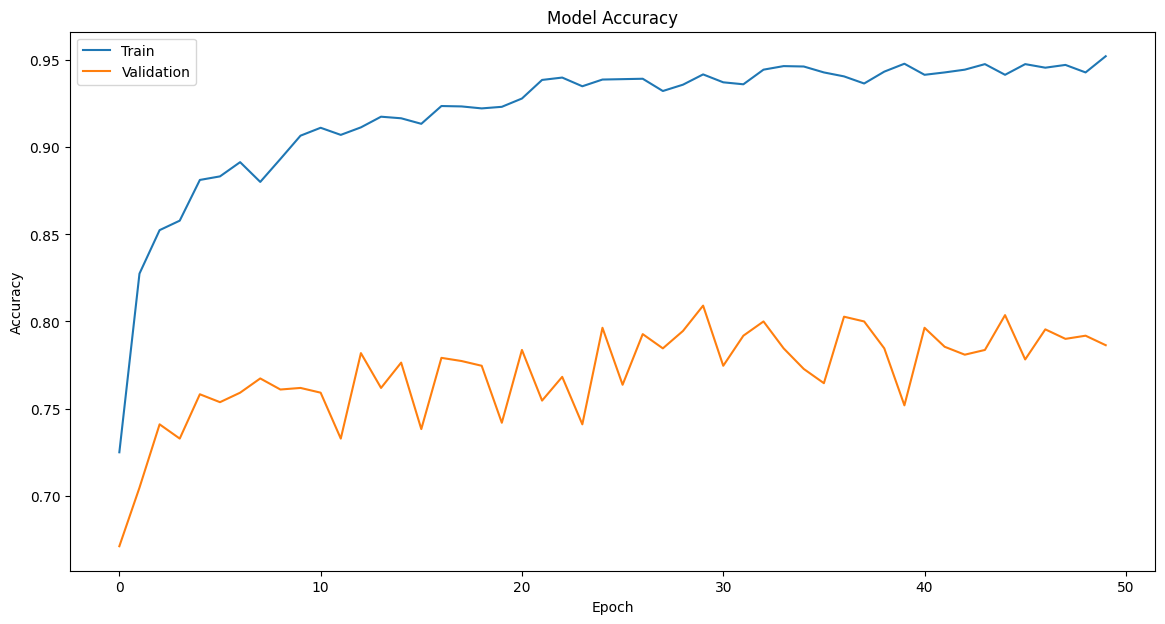

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot the Training and Validation Loss

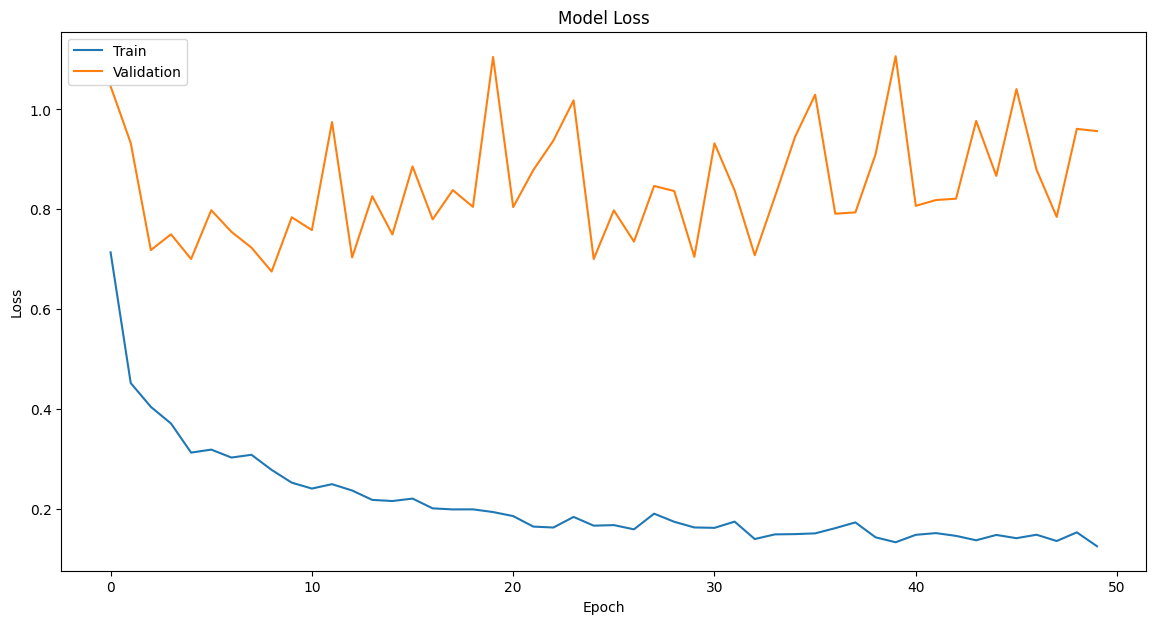

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test the model on the test data

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

41/41 [==============================] - 736s 18s/step - loss: 0.4670 - accuracy: 0.8751
Test accuracy: 0.8750975728034973


### Generate predictions on the test data

In [ ]:
y_pred = model.predict(test_generator, steps=len(test_generator))
y_true = test_generator.classes

41/41 [==============================] - 10s 241ms/step


### Generate and plot confusion matrix

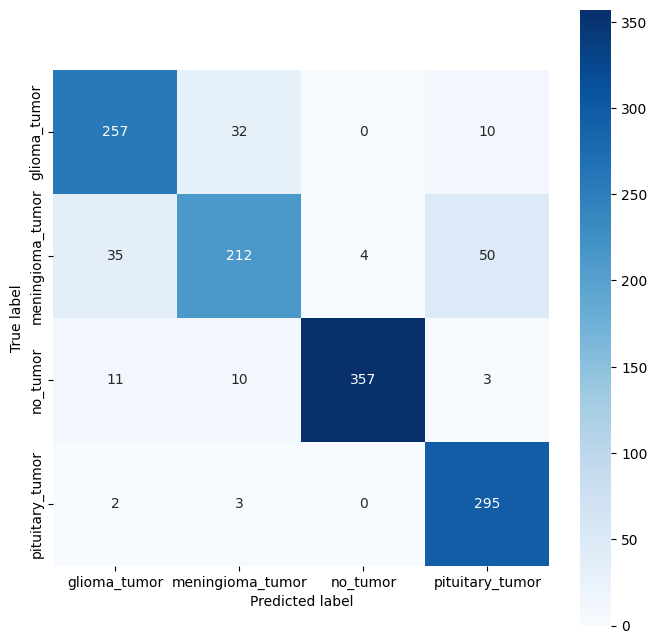

In [ ]:
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", square=True, xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Print classification report

In [ ]:
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.86      0.85       299
meningioma_tumor       0.82      0.70      0.76       301
        no_tumor       0.99      0.94      0.96       381
 pituitary_tumor       0.82      0.98      0.90       300

        accuracy                           0.88      1281
       macro avg       0.87      0.87      0.87      1281
    weighted avg       0.88      0.88      0.87      1281



### Compute precision, recall, F1 score and support for each class

In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1))

In [ ]:
# Create a dataframe with the computed metrics for each class
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Support': support
}, index=class_names)

# Print the dataframe
print(metrics_df)

                  Precision    Recall  F1 Score  Support
glioma_tumor       0.842623  0.859532  0.850993      299
meningioma_tumor   0.824903  0.704319  0.759857      301
no_tumor           0.988920  0.937008  0.962264      381
pituitary_tumor    0.824022  0.983333  0.896657      300


### Compute ROC and AUC for each class

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC and AUC for each class
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Plot ROC curve for each class

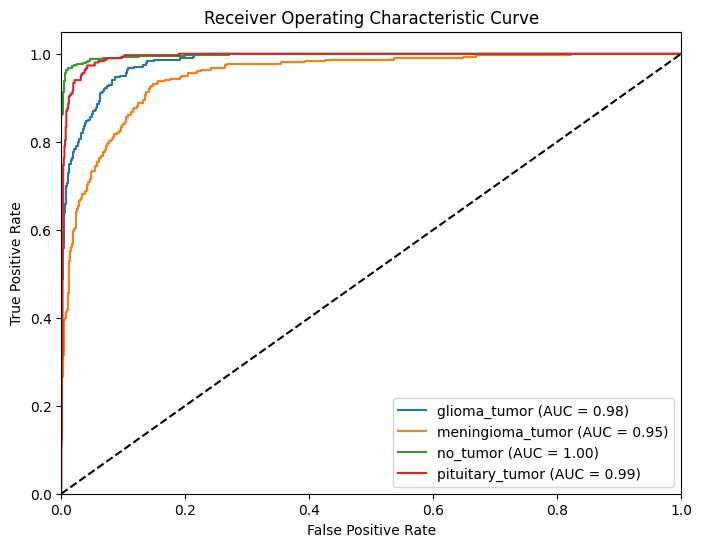

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label='%s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()